In [1]:
import pandas as pd
import numpy as np 

import geopandas as gpd
import shapely
import fiona
import folium

import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

In [2]:
SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_allsensors_8days/'

Importing output areas for spatial delimitation

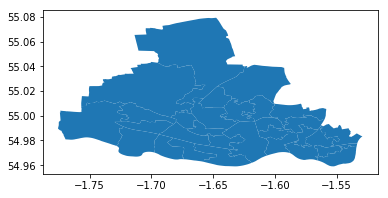

In [3]:
lsoa = gpd.read_file(SHAPE_FOLDER+'Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}

lsoa.plot()

Parsing metadata positions to geopandas/shapely geometries and filtering them by output areas

In [4]:
metadata = pd.read_csv(DATA_FOLDER+'sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')

metadata.shape

(260, 5)

Concating street features to metadata

In [32]:
sfeat = pd.read_csv(DATA_FOLDER+'street_features_newcastle.csv',index_col=0)
sfeat = sfeat.loc[metadata.index]
sfeat.shape

(260, 9)

Resampling sensors samples to a specific time frequency, acquiring medians to avoid outliers, and also samples inside output area

In [24]:
sensors = pd.read_csv(DATA_FOLDER+'data.csv')
sensors['Timestamp'] = pd.to_datetime(sensors['Timestamp'])
sensors = sensors.set_index(['Variable','Sensor Name','Timestamp'])

# resampling by freq
freq='H'
level_values = sensors.index.get_level_values
sensors = (sensors.groupby([level_values(i) for i in [0,1]]
                   +[pd.Grouper(freq=freq, level=-1)]).median())

# filtering by Newcastle's region
m = metadata.index.values
s = sensors.reset_index()
s = s.loc[s['Sensor Name'].isin(m)]
sensors = s.set_index(['Variable','Sensor Name','Timestamp'])

sensors.reset_index()['Sensor Name'].unique().shape

(260,)

Reducing metadata and sensors dataframes to consider less variables

In [25]:
variables = ['CO', 'Humidity', 'Journey Time', 'NO2', 'O3', 
             'PM10', 'Particle Count', 'Sound', 'Temperature', 
             'Wind Direction', 'Wind Speed']

sensors = sensors.loc[variables]
metadata = metadata.loc[sensors.index.get_level_values(1).unique()]

## 1. Feature ingestion

This consider a list of k neighbors measures for each time and variable, to predict a single target specified

In [61]:
def ingestion(sensors, metadata, sfeat, variables, k, target, method):
    idx = pd.IndexSlice
    zi = sensors.loc[target]
    zx = pd.DataFrame()
    for s in sensors.index.get_level_values(1).unique():
        i = metadata.loc[s]

        for t in sensors.index.get_level_values(2).unique():
            zkj = pd.DataFrame()
            zk = pd.DataFrame()
            zk['timestamp'] = [t]*k
            zk['zi'] = [i.name]*k
            zk['Sensor Name'] = range(0,k)
            zk.set_index(['zi','timestamp','Sensor Name'],inplace=True)

            for var in variables['sensors']:

                sdf = sensors.loc[idx[var,:,t],:] # sensors of the var variable at  time t 
                mdf = metadata.loc[sdf.index.get_level_values(1).unique()] # metadata about them

                dij = mdf['geometry'].apply(lambda x: i['geometry'].distance(x)).sort_values() # nearest measures for (var,t)
                dij = dij.loc[(dij.index!=i.name) & (dij>0)] # excluding the sensor i
                if method=='nn':
                    dij = dij[:k]
                elif method=='randomized':
                    dij = dij[:10].sample(k, random_state=0)

                zj = sdf.loc[idx[:,dij.index,:],:].reset_index([0,2])['Value']
                zj.name = var

                zj.index = range(0,k)
                dij.index = range(0,k)

                zk.loc[idx[i.name,t],'d_{}'.format(var)] = dij.values
                zk.loc[idx[i.name,t],var] = zj.values
                zkj = zk.melt().set_index('variable').T
                zkj.index = [t]
                zkj['zi'] = i.name
                zkj = zkj.reset_index().set_index(['zi','index'])
            zx = zx.append(zkj)
    if 'hour' in variables['exogenous']:
        zx['hour'] = zx.index.get_level_values(1).hour
    if 'dow' in variables['exogenous']:
        zx['dow'] = zx.index.get_level_values(1).dayofweek
    if 'day' in variables['exogenous']:
        zx['day'] = zx.index.get_level_values(1).day
    if 'month' in variables['exogenous']:
        zx['month'] = zx.index.get_level_values(1).month
    if 'year' in variables['exogenous']:
        zx['year'] = zx.index.get_level_values(1).year
      
    if 'street' in variables['exogenous']:
        try:
            zx = zx.reset_index([1]).join(sfeat).set_index('index',append=True).fillna(0)
        except:
            print('Warning: \'street\' variables are not available in metadata')
            pass

    zx = zx.loc[zi.index]
    zi = zi.loc[idx[zx.index.get_level_values(0).unique(),zx.index.get_level_values(1).unique()],:]    

    return zx, zi

In [62]:
variables = {
    'sensors':('NO2','Temperature'),
    'exogenous':('street','day','dow')
}

zx, zi = ingestion(sensors, metadata, sfeat, variables, k=3, target='NO2', method='randomized')
print(zx.shape,zi.shape)
zx.head()

(751, 23) (751, 1)


d_NO2     d_NO2     d_NO2        NO2  \
Sensor Name    Timestamp                                                      
aq_mesh1756150 2018-07-09 00:00:00  0.002386  0.003726  0.002772  36.987427   
               2018-07-09 01:00:00  0.002386  0.003726  0.002772  41.699981   
               2018-07-09 02:00:00  0.002386  0.003726  0.002772  35.878199   
               2018-07-09 03:00:00  0.002386  0.003726  0.002772  31.997052   
               2018-07-09 04:00:00  0.002386  0.003726  0.002772  26.392023   

                                          NO2        NO2  d_Temperature  \
Sensor Name    Timestamp                                                  
aq_mesh1756150 2018-07-09 00:00:00  45.487991  50.671561       0.002386   
               2018-07-09 01:00:00  49.992762  55.311328       0.002386   
               2018-07-09 02:00:00  41.134935  44.151418       0.002386   
               2018-07-09 03:00:00  34.679100  36.174706       0.002386   
               2018-07-09 04:00:00  25.952494  27.065767       0.002386   

                                    d_Temperature  d_Temperature  Temperature  \
Sensor Name    Timestamp                                                        
aq_mesh1756150 2018-07-09 00:00:00       0.003558       0.002772    20.700001   
               2018-07-09 01:00:00       0.003726       0.002772    16.600000   
               2018-07-09 02:00:00       0.003726       0.002772    16.700000   
               2018-07-09 03:00:00       0.003726       0.002772    16.300000   
               2018-07-09 04:00:00       0.003726       0.002772    16.000000   

                                      ...     day  cycleway  primary  \
Sensor Name    Timestamp              ...                              
aq_mesh1756150 2018-07-09 00:00:00    ...       9         0       11   
               2018-07-09 01:00:00    ...       9         0       11   
               2018-07-09 02:00:00    ...       9         0       11   
               2018-07-09 03:00:00    ...       9         0       11   
               2018-07-09 04:00:00    ...       9         0       11   

                                    secondary  service  footway  residential  \
Sensor Name    Timestamp                                                       
aq_mesh1756150 2018-07-09 00:00:00         13       89      120           10   
               2018-07-09 01:00:00         13       89      120           10   
               2018-07-09 02:00:00         13       89      120           10   
               2018-07-09 03:00:00         13       89      120           10   
               2018-07-09 04:00:00         13       89      120           10   

                                    traffic_signals  bus_stop  crossing  
Sensor Name    Timestamp                                                 
aq_mesh1756150 2018-07-09 00:00:00                6        78        14  
               2018-07-09 01:00:00                6        78        14  
               2018-07-09 02:00:00                6        78        14  
               2018-07-09 03:00:00                6        78        14  
               2018-07-09 04:00:00                6        78        14  

[5 rows x 23 columns]

In [23]:
# zx.to_csv(DATA_FOLDER+'zx_7days.csv')
# zi.to_csv(DATA_FOLDER+'zi_7days.csv')

### 1.a. Inverse Distance Weighting

In [162]:
def iwd_features(zx, sensor_variables):
    ziwd = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        ziwd['iwd_{}'.format(var)] = (((zx['d_{}'.format(var)].values*zx[var].values).sum(axis=1))/zx['d_{}'.format(var)].values.sum(axis=1))
    return ziwd
ziwd = inverse_distance_weighting(zx,zi, variables['sensors'])
ziwd.head()

iwd_NO2  iwd_Temperature
Sensor Name    Timestamp                                      
aq_mesh1756150 2018-07-09 00:00:00  44.822321        18.938947
               2018-07-09 01:00:00  49.425017        16.567777
               2018-07-09 02:00:00  40.664307        16.667777
               2018-07-09 03:00:00  34.425427        16.309719
               2018-07-09 04:00:00  26.417892        16.040920

### 1.b. Spatial Averaging

In [163]:
def spavg_features(zx, sensor_variables):
    zavg = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        zavg['spavg_{}'.format(var)] = zx[var].values.sum(axis=1)/zx[var].shape[1]
    return zavg   
zavg = spavg_features(zx, variables['sensors'])
zavg.head()

spavg_NO2  spavg_Temperature
Sensor Name    Timestamp                                        
aq_mesh1756150 2018-07-09 00:00:00  44.382326          19.100000
               2018-07-09 01:00:00  49.001357          16.600000
               2018-07-09 02:00:00  40.388184          16.700000
               2018-07-09 03:00:00  34.283619          16.333333
               2018-07-09 04:00:00  26.470095          16.066667

### 1.b. Nearest Neighbor

In [164]:
def nn_features(zx, sensor_variables):
    znn = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        znn['nn_{}'.format(var)] = zx[var].apply(lambda x: x.min(),axis=1)
    return znn
znn = nn_features(zx, variables['sensors'])
znn.head()

nn_NO2  nn_Temperature
Sensor Name    Timestamp                                     
aq_mesh1756150 2018-07-09 00:00:00  36.987427            18.1
               2018-07-09 01:00:00  41.699981            16.3
               2018-07-09 02:00:00  35.878199            16.4
               2018-07-09 03:00:00  31.997052            16.1
               2018-07-09 04:00:00  25.952494            15.8

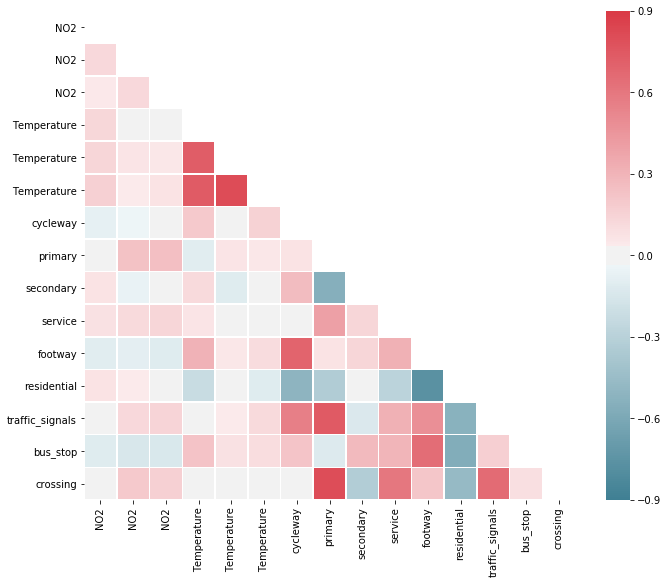

In [63]:
def corrplot(zx, variables):
    corr = zx[variables].corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    return  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, vmin=-.9,linewidths=.5)
corrplot(zx, ['NO2','Temperature','cycleway','primary','secondary','service','footway','residential','traffic_signals','bus_stop','crossing'])

## Regression example

Random Forest

In [165]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

paramsrf = {
    'n_estimators':np.arange(5,300,15),
    'max_features':np.arange(0.1, 1.01, 0.05),
    'max_depth':np.arange(1,20,2)
}
grid = RandomizedSearchCV(rf, param_distributions=paramsrf,
                    n_iter=100, scoring='r2', n_jobs=-1, cv=5).fit(zx.values, np.ravel(zi.values))
grid.best_score_

-0.9150820499534695

MultiLayer Perceptron

In [73]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(max_iter=10000)

paramsmlp = {
    'hidden_layer_sizes':[(3,1),(3,3),(3,5),(5,1),(5,3),(5,5),(10,1),(10,3),(10,5),(20,3),(20,5),(20,10)],
    'activation':['identity','relu','logistic'],
    'alpha':np.logspace(0.0001,0.1,50)
}

grid = RandomizedSearchCV(mlp, param_distributions=paramsmlp,
                    n_iter=50, scoring='r2', n_jobs=-1, cv=5).fit(zx.values, np.ravel(zi.values))
grid.best_score_

-0.5417282297494984

## Feature importance analysis

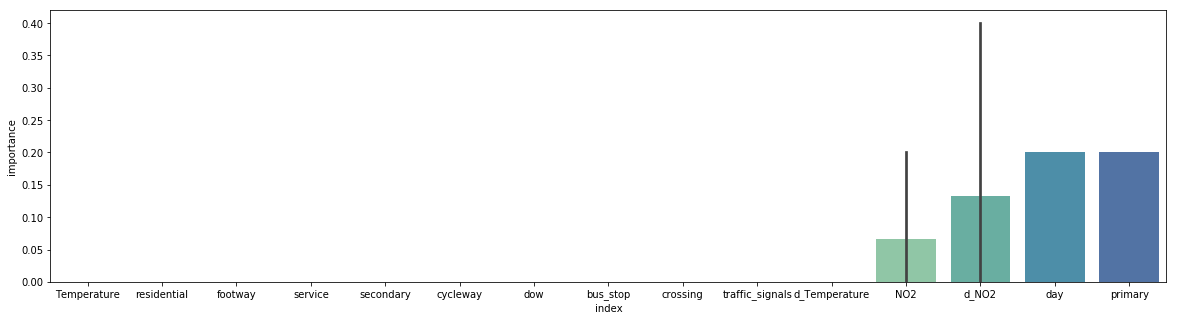

In [69]:
def featureimp_plot(grid, zx):
    importances = grid.best_estimator_.feature_importances_
    indices = zx.columns[np.argsort(importances)[::-1]]
    f = pd.DataFrame(importances, index=indices, columns=['importance']).reset_index().sort_values('importance')

    plt.figure(figsize=(20,5))
    return sns.barplot(x='index',y='importance',data=f, palette='Spectral')
featureimp_plot(grid,zx)